# Проект "Предсказание калорийности блюд"

## Постановка задачи
Создать и обучить нейросеть, которая будет **предсказывать калорийность блюд по фото и текстовому описанию**.

## Критерии успеха
- **MAE < 50**

<div class="alert alert-secondary" style="background-color:#D9EEE1;color:black;">

## Описание данных

[Датасет](https://disk.yandex.ru/d/kz9g5msVqtahiw) (1.3 ГБ) содержит фотографии блюд, описание ингредиентов, а также общую массу порции и калорийность.

- data/ingredients.csv
    - `id` — ID ингредиента.
    - `ingr` — название ингредиента.
- data/dish.csv
    - `dish_id` — ID блюда.
    - `total_calories` — общее число калорий. Это целевая переменная.
    - `total_mass` — масса блюда.
    - `ingredients` — список всех ID ингредиентов в формате ingr_0000000122;ingr_0000000026;.., где ненулевая часть соответствует ID ингредиента из data/ingredients.csv.
    - `split` — метка, указывающая, куда отнести блюдо: train/test. Эта метка поможет разделить датасет при тренировке.
- data/images
    - датасет с фотографиями блюд, каждая директория соответствует `dish_id` из data/dish.csv и содержит `rgb.png` фото блюда.


- **Целевой признак:**
    - data/dish.csv \ `total_calories`

# Инициализация

## Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from config import Config
from utils import train, inference
import re

import phik

c:\ProgramData\anaconda3\envs\practicumNLP-py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Установка главных параметров

In [4]:
config = Config

In [5]:
if config.COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

# Загрузка и предобработка данных, исследовательский анализ (EDA)

In [6]:
def load_df (csv):
    df = pd.read_csv (os.path.join (config.ROOT_PATH, csv))
    display(df.head())
    display(df.info())
    return df

In [7]:
ingredients_df =  load_df('data/ingredients.csv')

id            ingr
0   1  cottage cheese
1   2    strawberries
2   3    garden salad
3   4           bacon
4   5        potatoes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      555 non-null    int64 
 1   ingr    555 non-null    object
dtypes: int64(1), object(1)
memory usage: 8.8+ KB


None

In [8]:
dish_df = load_df('data/dish.csv')

dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  
0  ingr_0000000508;ingr_0000000122;ingr_000000002...   test  
1  ingr_0000000312;ingr_0000000026;ingr_000000002...  train  
2  ingr_0000000448;ingr_0000000520;ingr_000000046...   test  
3    ingr_0000000471;ingr_0000000031;ingr_0000000347  train  
4                                    ingr_0000000453  train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dish_id         3262 non-null   object 
 1   total_calories  3262 non-null   float64
 2   total_mass      3262 non-null   float64
 3   ingredients     3262 non-null   object 
 4   split           3262 non-null   object 
dtypes: float64(2), object(3)
memory usage: 127.6+ KB


None

Посмотрим, сколько бывает ингридиентов:

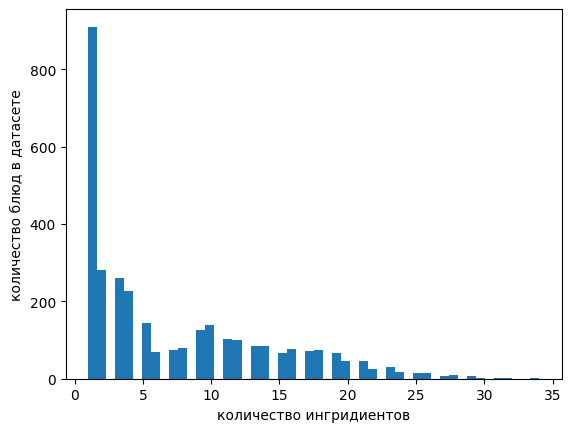

In [9]:
dish_df ['ingredients_cnt'] = dish_df['ingredients'] \
                                .apply (lambda x: len(x.split(';')))
ax = dish_df ['ingredients_cnt'].plot.hist(bins=50);
ax.set_xlabel("количество ингридиентов")
ax.set_ylabel("количество блюд в датасете");

Максимальное количество ингридиентов:

In [10]:
max(dish_df ['ingredients_cnt'])

34

После курса DS руки тянутся применить OHE. Но, видимо, тут всё же нужно оставить ингридиенты в текстовом представлении, ведь при инференсе могут использоваться новые слова в описаниях, и эмбеддинг трансформера тут отработает лучше. Заменим идентификаторы на названия ингридиентов, разделив их запятыми:

Прежде - подготовим словарь ингридиентов

In [11]:
ingredients_dict = ingredients_df.set_index('id')['ingr'].to_dict()
ingredients_dict

{1: 'cottage cheese',
 2: 'strawberries',
 3: 'garden salad',
 4: 'bacon',
 5: 'potatoes',
 6: 'caesar salad',
 7: 'cauliflower',
 8: 'scrambled eggs',
 9: 'wild rice',
 10: 'steak',
 11: 'cheese pizza',
 12: 'olives',
 13: 'berries',
 14: 'asparagus',
 15: 'hash browns',
 16: 'brussels sprouts',
 17: 'pasta salad',
 18: 'turkey',
 19: 'bread',
 20: 'duck',
 21: 'squash',
 22: 'guacamole',
 23: 'brown rice',
 24: 'artic char',
 25: 'beef',
 26: 'white rice',
 27: 'broccoli',
 28: 'chicken',
 29: 'mixed greens',
 30: 'lettuce',
 31: 'cucumbers',
 32: 'tomatoes',
 33: 'bell peppers',
 34: 'celery',
 35: 'blue cheese',
 36: 'spinach (raw)',
 37: 'cantaloupe',
 38: 'pineapple',
 39: 'sausage',
 40: 'raspberries',
 41: 'blackberries',
 42: 'avocado',
 43: 'green beans',
 44: 'bean sprouts',
 45: 'carrot',
 46: 'mushroom',
 47: 'corn',
 48: 'ham',
 49: 'fish',
 50: 'tofu',
 51: 'shrimp',
 52: 'cheese',
 53: 'nuts',
 54: 'apple',
 55: 'banana',
 56: 'kiwi',
 57: 'lemon',
 58: 'orange',
 59: '

In [12]:
def extract_ingr_number(s):
    # Ищем числа только после 'ingr_'
    match = re.search(r'ingr_(\d+)', s)
    if match:
        return int(match.group(1))
    return None

def ingridients_id_to_text (text):
    ingr_ids = [extract_ingr_number(s) for s in text.split(';')]
    ingr_txt = [ingredients_dict[id] if id is not None else "" for id in ingr_ids]
    text = ', '.join(ingr_txt)
    return text

dish_df ['ingredients'] = dish_df ['ingredients'].apply (ingridients_id_to_text)
dish_df.head()

dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  ingredients_cnt  
0  soy sauce, garlic, white rice, parsley, onions...   test               17  
1  pepper, white rice, mixed greens, garlic, soy ...  train               17  
2  jalapenos, lemon juice, pork, wheat berry, cab...   test               13  
3           cherry tomatoes, cucumbers, baby carrots  train                3  
4                                         deprecated  train                1

Посмотрим на блюда тренировочного датасета:

In [13]:
train_dish_df = dish_df.loc[dish_df['split']=="train"].reset_index(drop=True)
test_dish_df = dish_df.loc[dish_df['split']=="test"].reset_index(drop=True)

⬇------------------- блюдо dish_1560456853 -------------------⬇
Ингридиенты: parsley, salt, broccoli, fish, jicama, olive oil, sour cream, nopales, lime, chive, carrot, corn, garlic, caesar salad, pepper, arugula, wild rice
Грамм: 501.0
Калорий: 405.703369


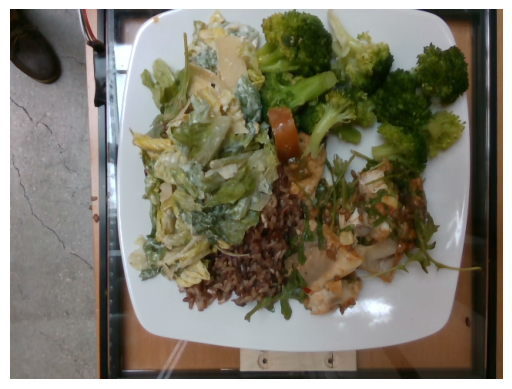

⬇------------------- блюдо dish_1560356314 -------------------⬇
Ингридиенты: spinach (raw), vinegar, olive oil, tomatoes, salt, garlic, mustard, cucumbers, mustard greens
Грамм: 27.0
Калорий: 30.544943


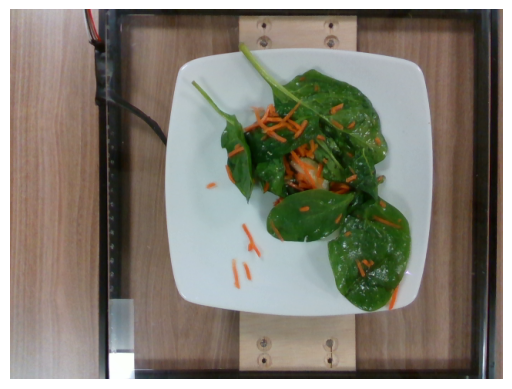

⬇------------------- блюдо dish_1561578344 -------------------⬇
Ингридиенты: onions, cucumbers, cheese pizza, lettuce, olives, bell peppers, vinaigrette, cherry tomatoes, feta cheese
Грамм: 86.0
Калорий: 144.255859


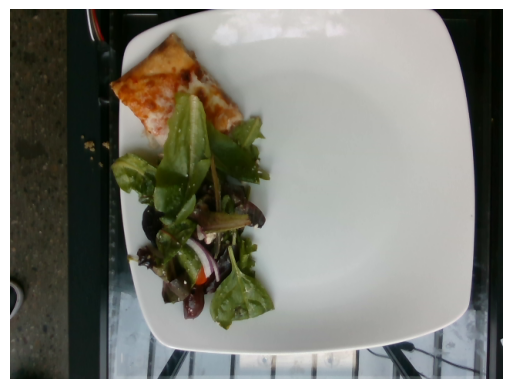

In [14]:
IMAGES_CNT=3
def show_samples (df, n_samples = IMAGES_CNT, fields_to_show = []):
    i = 0
    for _, dish in df.sample(n_samples).iterrows():

        image_path = os.path.join(config.ROOT_PATH, 'data/images', dish['dish_id'], 'rgb.png')
        image = Image.open(image_path)
        
        print (f"⬇------------------- блюдо {dish['dish_id']} -------------------⬇")
        print (f"Ингридиенты: {dish['ingredients']}")
        print (f"Грамм: {dish['total_mass']}")
        print (f"Калорий: {dish['total_calories']}")
        for f in fields_to_show:
            print (f"{f}: {dish[f]}")
        plt.imshow(image)
        plt.axis('off')
        plt.show()

show_samples (train_dish_df)

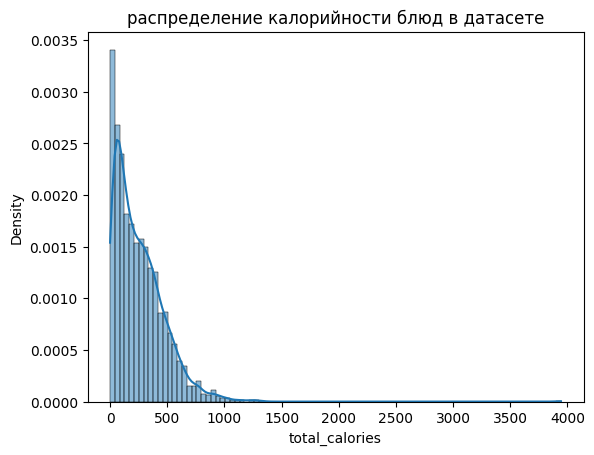

In [15]:
sns.histplot(data=train_dish_df, x='total_calories', stat='density', 
             common_norm=False, kde=True)
plt.title("распределение калорийности блюд в датасете");

In [16]:
train_dish_df['total_calories'].describe()

count    2755.000000
mean      254.929131
std       221.009051
min         0.000000
25%        81.805329
50%       208.115997
75%       376.573365
max      3943.325195
Name: total_calories, dtype: float64

Интересно, что за блюда имеют калории = около 0?

⬇------------------- блюдо dish_1556575700 -------------------⬇
Ингридиенты: plate only
Грамм: 86.0
Калорий: 0.0


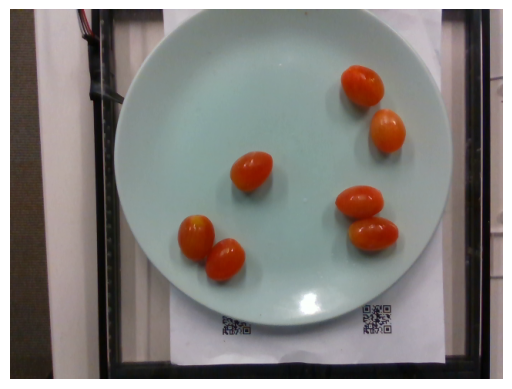

In [17]:
tmp_df = train_dish_df.query('total_calories == 0')
show_samples (tmp_df, min(IMAGES_CNT, tmp_df.shape[0]))

Посмотрим также на самые калорийные блюда:

⬇------------------- блюдо dish_1560974769 -------------------⬇
Ингридиенты: spinach (raw), tortilla chips, corn, cheese, white rice, cherry tomatoes, lime, tomatoes, chili, garlic, salt, sour cream, onions, black beans
Грамм: 3051.0
Калорий: 3943.325195


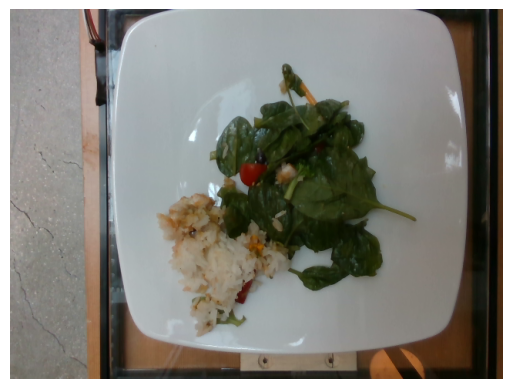

In [18]:
tmp_df = train_dish_df.query('total_calories > 3500')
show_samples (tmp_df, min(IMAGES_CNT, tmp_df.shape[0]))

Это странно, тут не может быть 3900 калорий.

Посмотрим на блюда больше 2000 калорий:

⬇------------------- блюдо dish_1560974769 -------------------⬇
Ингридиенты: spinach (raw), tortilla chips, corn, cheese, white rice, cherry tomatoes, lime, tomatoes, chili, garlic, salt, sour cream, onions, black beans
Грамм: 3051.0
Калорий: 3943.325195


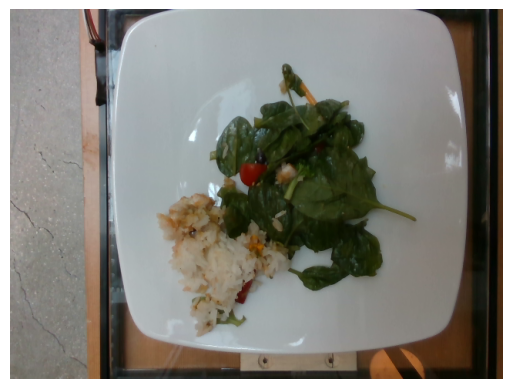

In [19]:
tmp_df = train_dish_df.query('total_calories > 2000')
show_samples (tmp_df, min(IMAGES_CNT, tmp_df.shape[0]))

Посмотрим на блюда больше 1000 калорий:

⬇------------------- блюдо dish_1568401090 -------------------⬇
Ингридиенты: broccoli, mixed greens, avocado, olive oil, chicken
Грамм: 614.0
Калорий: 1158.98999


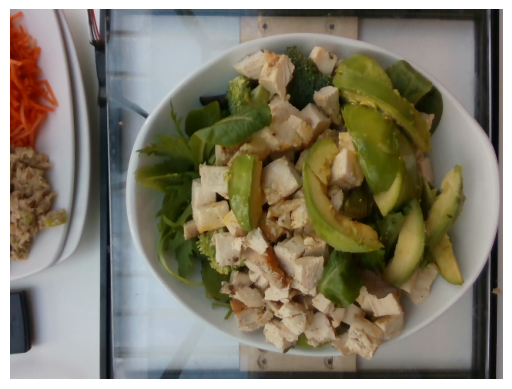

⬇------------------- блюдо dish_1562603867 -------------------⬇
Ингридиенты: mixed greens, hash browns, raspberries, blackberries, sausage, vinaigrette, granola
Грамм: 369.0
Калорий: 1049.11731


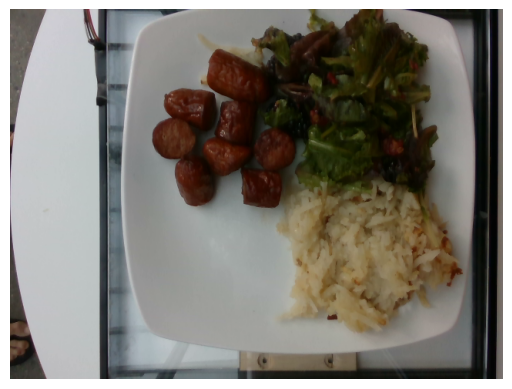

⬇------------------- блюдо dish_1568318480 -------------------⬇
Ингридиенты: mixed greens, chicken, olive oil, steak, broccoli
Грамм: 587.0
Калорий: 1119.280029


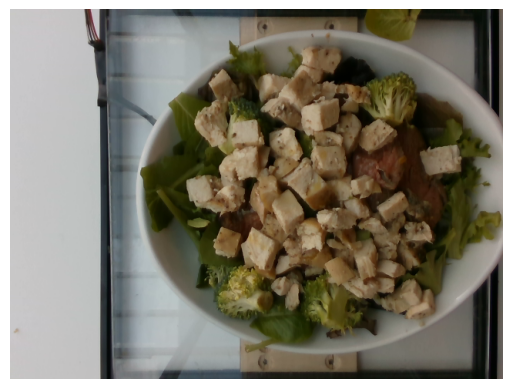

In [20]:
tmp_df = train_dish_df.query('total_calories > 1000')
show_samples (tmp_df, min(IMAGES_CNT, tmp_df.shape[0]))

Выше 2000 калорий - только было только одно блюдо, и оно явно не тянет на свои 3900+ калорий (судя по ингридиентам), удалим его:

In [21]:
dish_df = dish_df.query('total_calories <= 2000')
train_dish_df = train_dish_df.query('total_calories <= 2000')

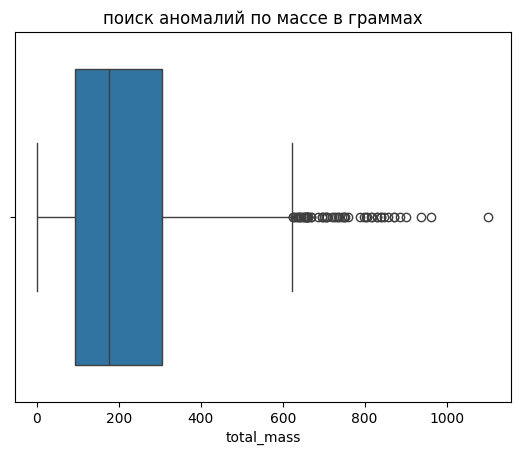

In [22]:
ax = sns.boxplot(data=dish_df, orient="h", y = None, x = 'total_mass');
ax.set_title('поиск аномалий по массе в граммах');

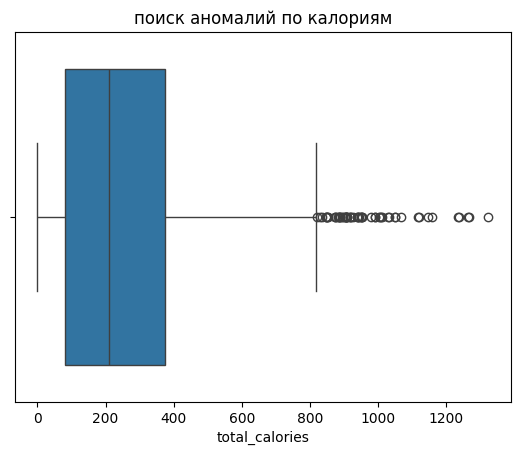

In [23]:
ax = sns.boxplot(data=dish_df, orient="h", y = None, x = 'total_calories');
ax.set_title('поиск аномалий по калориям');

Посмотрим на такие блюда, аномальные по массе:

⬇------------------- блюдо dish_1565884833 -------------------⬇
Ингридиенты: watermelon, egg whites, waffles, salsa
Грамм: 643.0
Калорий: 497.739014


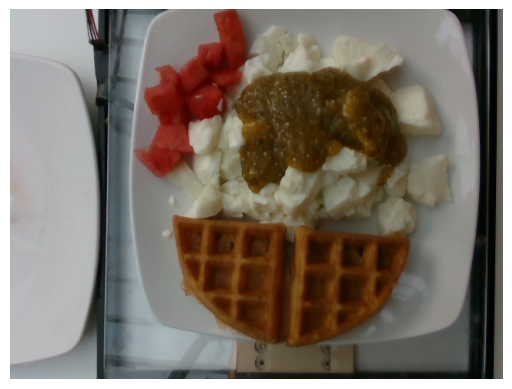

⬇------------------- блюдо dish_1564590288 -------------------⬇
Ингридиенты: pineapple, watermelon, egg whites, berries, cantaloupe, sweet potato, olive oil
Грамм: 848.0
Калорий: 464.855835


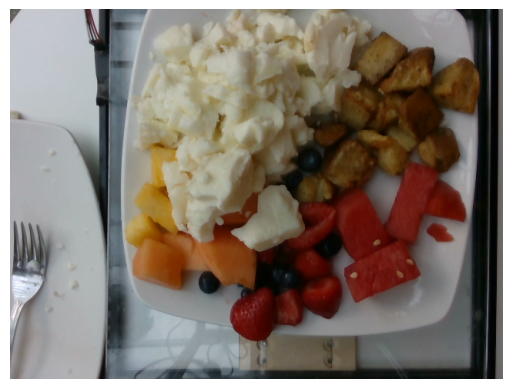

⬇------------------- блюдо dish_1565107211 -------------------⬇
Ингридиенты: salsa, sweet potato, scrambled eggs, olive oil, egg whites, watermelon, grapes
Грамм: 799.0
Калорий: 523.634644


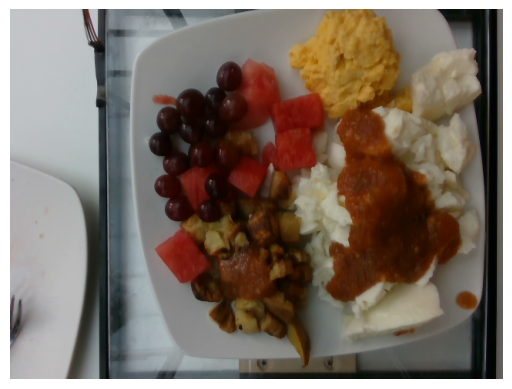

In [24]:
tmp_df = train_dish_df.query('total_mass > 600')
show_samples (tmp_df, min(IMAGES_CNT, tmp_df.shape[0]))

Фото "аномальных" блюд тяжелее 600 г не выглядят подозрительно, удалять из, кажется, что не стоит.

Посмотрим на такие блюда, аномальные по калориям:

⬇------------------- блюдо dish_1562180157 -------------------⬇
Ингридиенты: olive oil, almonds, spinach (raw), mustard, bacon, chicken, carrot, salt, vegetable oil, blueberries, squash, vinegar, buttermilk, flour, garlic, parsley, lemon juice, thyme
Грамм: 557.0
Калорий: 1009.176697


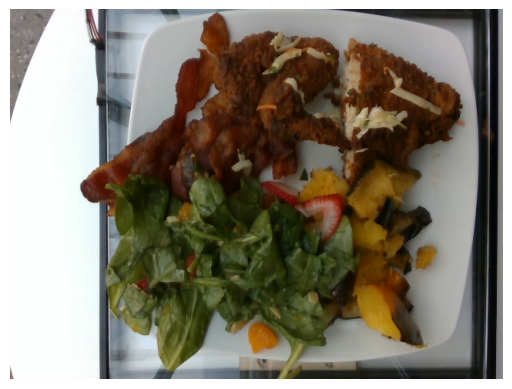

⬇------------------- блюдо dish_1568318480 -------------------⬇
Ингридиенты: mixed greens, chicken, olive oil, steak, broccoli
Грамм: 587.0
Калорий: 1119.280029


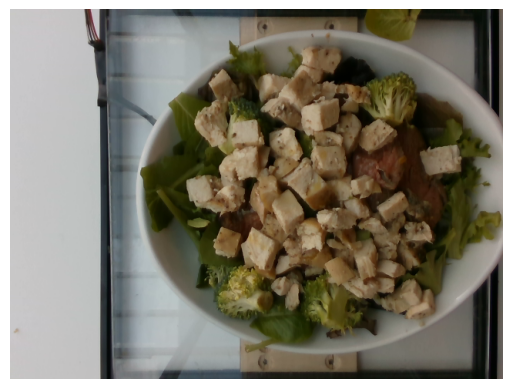

⬇------------------- блюдо dish_1563567372 -------------------⬇
Ингридиенты: cherry tomatoes, fish, salt, wheat berry, lemon juice, chard, kale, parsley, olive oil, pizza, shallots, garlic, chive
Грамм: 590.0
Калорий: 951.910889


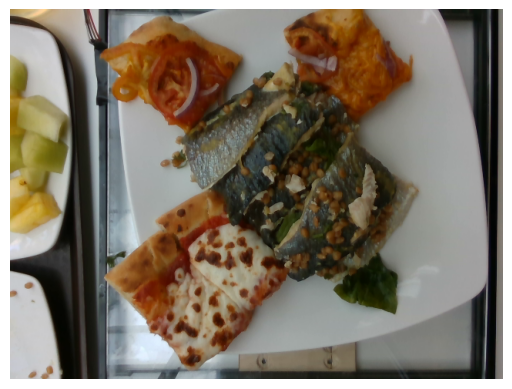

In [25]:
tmp_df = train_dish_df.query('total_calories > 800')
show_samples (tmp_df, min(IMAGES_CNT, tmp_df.shape[0]))

Фото "аномальных" блюд калорийнее 800 г не выглядят подозрительно, удалять из, кажется, что не стоит.

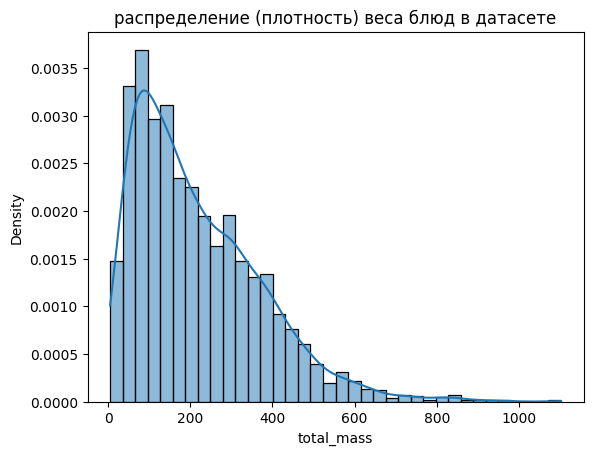

In [26]:
sns.histplot(data=train_dish_df, x='total_mass', stat='density', 
             common_norm=False, kde=True)
plt.title("распределение (плотность) веса блюд в датасете");

In [27]:
train_dish_df['total_mass'].describe()

count    2754.000000
mean      216.982571
std       153.920393
min         5.000000
25%        94.000000
50%       179.000000
75%       308.000000
max      1102.000000
Name: total_mass, dtype: float64

Интересно, что за блюда имеют массу < 10 г.?

⬇------------------- блюдо dish_1560370804 -------------------⬇
Ингридиенты: ice cream cones
Грамм: 6.0
Калорий: 25.134001


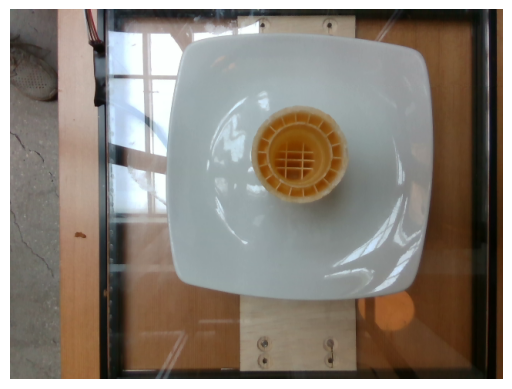

⬇------------------- блюдо dish_1559841571 -------------------⬇
Ингридиенты: cereal
Грамм: 5.0
Калорий: 18.799999


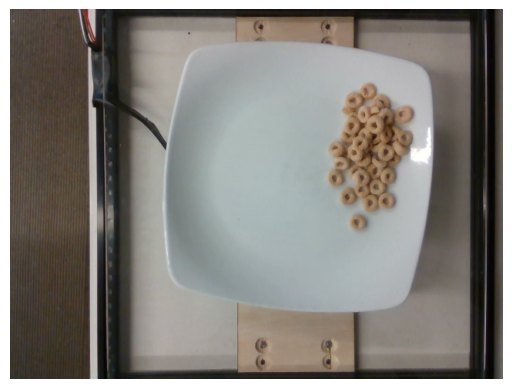

⬇------------------- блюдо dish_1558460205 -------------------⬇
Ингридиенты: spinach (raw)
Грамм: 8.0
Калорий: 1.84


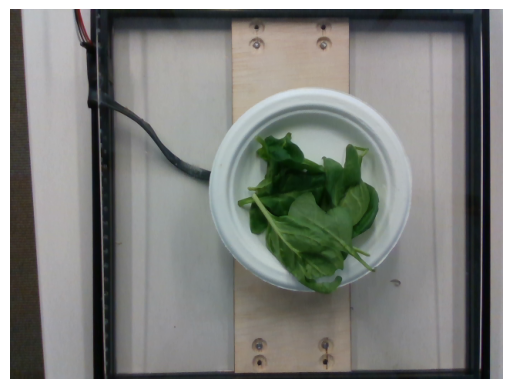

In [28]:
tmp_df = train_dish_df.query('total_mass < 10')
show_samples (tmp_df, min(IMAGES_CNT, tmp_df.shape[0]))

Интересно, что за блюда имеют массу > 1 кг.?

⬇------------------- блюдо dish_1561739805 -------------------⬇
Ингридиенты: raspberries, broccoli, berries, sweet potato, scrambled eggs, cantaloupe, vinaigrette, mixed greens, blackberries, granola
Грамм: 1102.0
Калорий: 696.363525


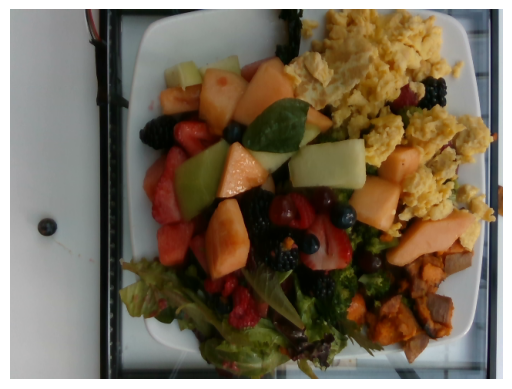

In [29]:
tmp_df = train_dish_df.query('total_mass > 1000')
show_samples (tmp_df, min(IMAGES_CNT, tmp_df.shape[0]))

После удаления, построим заново статистику:

In [30]:
train_dish_df['total_calories'].describe()

count    2754.000000
mean      253.589844
std       209.569402
min         0.000000
25%        81.732666
50%       208.107071
75%       376.455490
max      1324.084961
Name: total_calories, dtype: float64

In [31]:
train_dish_df['total_mass'].describe()

count    2754.000000
mean      216.982571
std       153.920393
min         5.000000
25%        94.000000
50%       179.000000
75%       308.000000
max      1102.000000
Name: total_mass, dtype: float64

In [32]:
dish_df['split'].value_counts(normalize=True)

split
train    0.844526
test     0.155474
Name: proportion, dtype: float64

In [33]:
dish_df['split'].value_counts()

split
train    2754
test      507
Name: count, dtype: int64

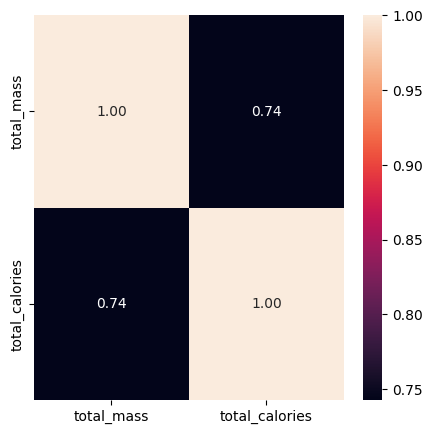

In [34]:
interval_cols=['total_mass', 'total_calories']
   
bins = {}
for c in interval_cols:
    bins[c] = 10;

_, ax = plt.subplots(figsize=(5,5))
ph_mx = dish_df[['total_mass', 'total_calories']].phik_matrix(interval_cols=interval_cols, bins=bins)
sns.heatmap(ph_mx, annot=True, fmt='.2f', ax=ax);

Из курса про DS:

*Как правило, о мультиколлинеарности говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю. В такой ситуации лишние коррелирующие признаки нужно удалять из обучающей выборки.*

В нашем случае мультиколлинеарности и утечки признака из-за массы не будет, поэтому его можно использовать.

## Выводы по итогам EDA и предобработки (тренировочного датасета)

- Решать задачу будем умножением текстового и картиночного эмбеддингов и обучением своей регрессионной головы над ними.
- Для аугментации применим повороты/кроп/перспективу/зашумление изображений (т. к. пользватели могут поворачивать/приближать/менять наклон камеры, снимать при недостатке освещения), будем менять светлоту. Вставлять опечатки в этот раз не будем, т. к. как сказано в лекциях это обычно даёт небольшой прирост к метрике, да и инструментов готовых для этого не было представлено в лекциях, хотя они легко гуглятся: NLPAug, TextAttack, nlpaug (и жёсткий дедлайн уже завтра).
- При обучении будем ориентироваться на целевую метрику - MAE
- В датафрейме идентификаторы ингридиентов заменены на их текстовые представления, перечисленные через запятую
- Наблюдения по датасету:
    - найдено одно блюдо с завышенным калоражем, оно выбивалось как аномалия и было удалено.
    - минимальный калораж блюда = 0 калорий, минимальный вес = 5 г (листья, ягоды, орехи).
    - медианный калораж блюда = 208 калорий, медианный вес = 179 г.
    - максимальный калораж блюда = 1324 калорий, максимальный вес = 1102 г (большие порции с разнообразными ингридиентами).
    - 75% блюд не превышают 376 калорий
    - всего в словаре 555 различных ингридиентов
    - максимальное количество различных ингридиентов в одном блюде = 34
    - соотношение тренировочного (2754 блюд) и тестового (507 блюд) датасетов: 84% и 16%

# Реализация пайплайн обучения

см. 
- config.py
- dataset.py
- utils.py

# Обучение модели

In [ ]:
%%time

train (config, train_dish_df, test_dish_df)

# Валидация качества

In [ ]:
if not os.path.exists(config.SAVE_PATH):
    raise FileNotFoundError("Модель не найдена.")
else:
    test_dish_df['predicted_calories'] = inference (config, test_dish_df)
    test_dish_df['loss'] = round(abs (test_dish_df['predicted_calories'] - test_dish_df['total_calories']), 2)   

Посмотрим на топ-5 самых простых примеров для модели:

In [ ]:
tmp_df = test_dish_df.sort_values(by='loss').head()
show_samples (tmp_df, 5, ['loss'])

Посмотрим на топ-5 самых тяжёлых примеров для модели:

In [ ]:
tmp_df = test_dish_df.sort_values(by='loss').tail()
show_samples (tmp_df, 5, ['loss'])

In [ ]:
test_dish_df['loss'].describe()

# Выводы

- Начиная с 4ой эпохи модель вышла на плато и далее перестала обучаться
- Также видно, что сразу MAE на val была ниже, чем на train, что может служить признаком переобучения.
- Медианная ошибка на val ~44 калории
- Средняя ошибка 70%, что не дотягивает до нужного порога в 50%
    - прошу ревюера направить в нужную сторону.
- Топ-5 наиболее сложных для модели блюд - объединяет большая порция из разнообразных ингридиентов.